In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dir_root = ''
# If using google colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    dir_root = '/content/drive/MyDrive/Colab Notebooks/ESE546/hw2'

print(dir_root)


### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [3]:
# Define the dataset directory
data_dir = os.path.join(dir_root, 'data')
print(data_dir)

if not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py')):
    download = True
    print('Dataset not found, downloading...')
else:
    download = False
    print('Dataset found, not downloading.')

# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=download, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=download, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

data
Dataset found, not downloading.


In [4]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the logger
logger = SummaryWriter(os.path.join(dir_root, 'runs/cnn_experiment'))

In [5]:
# # The training loop for 50 epochs

# def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
#     model = net.to(device)
#     total_step = len(train_loader)
#     overall_step = 0
#     train_loss_values = []
#     train_error = []
#     val_loss_values = []
#     val_error = []
#     for epoch in range(epochs):
#         correct = 0
#         total = 0
#         flag = 0
#         running_loss = 0.0
#         if epoch == 25 and flag == 0:
#           for op_params in optimizer.param_groups:
#             op_params['lr'] = 0.001
#           flag = 1
#         for i, (images, labels) in enumerate(train_loader):
#             # Move tensors to configured device
#             images = images.to(device)
#             labels = labels.to(device)
#             #Forward Pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             optimizer.step()
#             if (i+1) % 1000 == 0:
#               print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
#             if plot:
#               info = { ('loss_' + model_name): loss.item() }

#               for tag, value in info.items():
#                 logger.add_scalar(tag, value, overall_step+1)
#         train_loss_values.append(running_loss)
#         train_error.append(100-100*correct/total)

#         model.eval()
#         with torch.no_grad():
#             correct = 0
#             total = 0
#             for i, (images, labels) in enumerate(test_loader):
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
#         val_error.append(100-100*correct/total)
#         val_loss_values.append(running_loss)
#     return val_error,val_loss_values,train_error,train_loss_values


In [6]:
# model_path_50 = os.path.join(dir_root, 'runs/hw2p3_model_1_50_epoch.pt')

# if not os.path.exists(model_path_50):
#     model = allcnn_t().to(device)
#     epochs = 50
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001, nesterov=True)
#     val_error, val_loss_values, train_error, train_loss_values = train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)
#     torch.save(model, model_path_50)
# else:
#     print(f"Model already exists at {model_path_50}, skipping training.")

In [7]:
# Training 100 epochs using the same configuration, except that:
# Learning rate of 0.1 for the first 40 epochs, then 0.01 for the next 40 epochs
# and then 0.001 for the final 20 epochs.
# Weight decay = 1e-3
# SGD with Nesterov’s momentum of 0.9
# Plot the training and validation losses and errors with the number of epochs


def adjust_learning_rate(optimizer, epoch, lr_array):
    if epoch < 40:
        lr = lr_array[0]
    elif epoch < 80:
        lr = lr_array[1]
    else:
        lr = lr_array[2]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot, scheduled_lr_array):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0

        adjust_learning_rate(optimizer, epoch, scheduled_lr_array)
        print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              for tag, value in info.items():
                logger.add_scalar(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100 - 100 * correct / total)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100 - 100 * correct / total)
        val_loss_values.append(val_running_loss)
    return val_error, val_loss_values, train_error, train_loss_values


In [11]:
model_path_100 = os.path.join(dir_root, 'runs/hw2p3_model_100_epoch.pt')

TRAIN_FLAG = True

if not os.path.exists(model_path_100) or TRAIN_FLAG:
    model = allcnn_t().to(device)
    epochs = 100
    scheduled_lr = [0.02, 0.0005, 0.00001]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001, nesterov=True)

    val_error, val_loss_values, train_error, train_loss_values = train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve_100', True, scheduled_lr)

    torch.save(model, model_path_100)

    np.save(os.path.join(dir_root, 'runs/train_error_100.npy'), np.array(train_error))
    np.save(os.path.join(dir_root, 'runs/train_loss_values_100.npy'), np.array(train_loss_values))
    np.save(os.path.join(dir_root, 'runs/val_error_100.npy'), np.array(val_error))
    np.save(os.path.join(dir_root, 'runs/val_loss_values_100.npy'), np.array(val_loss_values))
else:
    print(f"Model already exists at {model_path_100}, skipping training.")

Num parameters:  1667166
Epoch 1, Learning Rate: 0.02
Epoch [1/5], Step [1000/3125], Loss: 1.5012
Epoch [1/5], Step [2000/3125], Loss: 1.4686
Epoch [1/5], Step [3000/3125], Loss: 1.4169
Accuracy of the network on the test images: 53.17 %
Epoch 2, Learning Rate: 0.02
Epoch [2/5], Step [1000/3125], Loss: 1.2395
Epoch [2/5], Step [2000/3125], Loss: 0.8478
Epoch [2/5], Step [3000/3125], Loss: 1.1381
Accuracy of the network on the test images: 65.98 %
Epoch 3, Learning Rate: 0.02
Epoch [3/5], Step [1000/3125], Loss: 0.6937
Epoch [3/5], Step [2000/3125], Loss: 1.0050
Epoch [3/5], Step [3000/3125], Loss: 0.6558
Accuracy of the network on the test images: 70.49 %
Epoch 4, Learning Rate: 0.02
Epoch [4/5], Step [1000/3125], Loss: 0.4052
Epoch [4/5], Step [2000/3125], Loss: 1.1392
Epoch [4/5], Step [3000/3125], Loss: 0.4830
Accuracy of the network on the test images: 72.06 %
Epoch 5, Learning Rate: 0.02
Epoch [5/5], Step [1000/3125], Loss: 0.9050
Epoch [5/5], Step [2000/3125], Loss: 0.6190
Epoch 

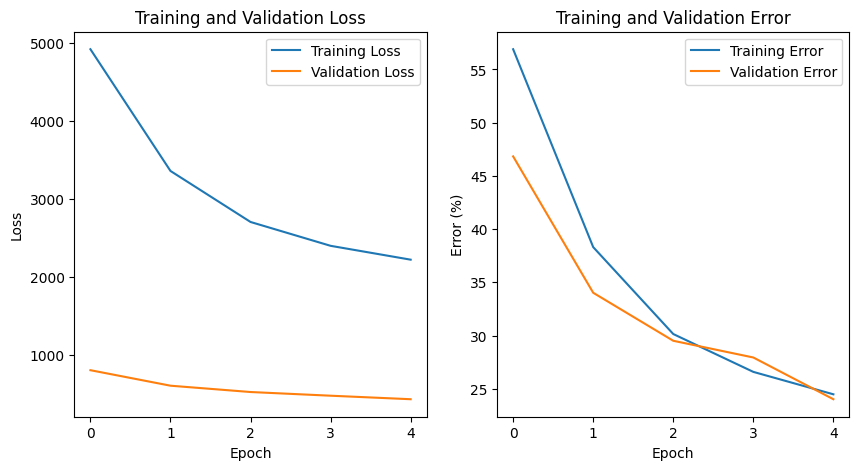

In [12]:
# Plot the training and validation losses and errors with the number of epochs
# First load the saved data
if os.path.exists(model_path_100) and not TRAIN_FLAG:
    train_error = np.load(os.path.join(dir_root, 'runs/train_error_100.npy'))
    train_loss_values = np.load(os.path.join(dir_root, 'runs/train_loss_values_100.npy'))
    val_error = np.load(os.path.join(dir_root, 'runs/val_error_100.npy'))
    val_loss_values = np.load(os.path.join(dir_root, 'runs/val_loss_values_100.npy'))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(train_loss_values), label='Training Loss')
plt.plot(np.array(val_loss_values), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.array(train_error), label='Training Error')
plt.plot(np.array(val_error), label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error (%)')
plt.title('Training and Validation Error')
plt.legend()
plt.show()


In [12]:
# Load the model
model = torch.load(model_path_100)
model.eval()

C:\Users\Bw Jiang\AppData\Local\Temp\ipykernel_16956\1671848212.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path_100)


allcnn_t(
  (m): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Dropout(p=0.5, inplace=False)
    (5): Sequential(
      (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True)
imgs, labels = next(iter(testloader))
imgs = imgs.to(device)
labels = labels.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001, nesterov=True)

imgs.requires_grad = True
optimizer.zero_grad()
outputs = model(imgs)
loss = criterion(outputs, labels)
loss.backward()
dx = imgs.grad.data.clone()

len(imgs)

100

In [19]:
_, predicted = torch.max(outputs.data, 1)
print(f"Predicted: {predicted}")
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

correct_pred = np.where(predicted == labels)
incorrect_pred = np.where(predicted != labels)

print(f"Correctly predicted: {correct_pred}")
print(f"Incorrectly predicted: {incorrect_pred}")

Predicted: tensor([5, 4, 2, 9, 3, 2, 2, 5, 4, 0, 1, 5, 8, 2, 6, 1, 6, 3, 4, 1, 1, 7, 4, 5,
        2, 5, 6, 7, 4, 8, 0, 8, 5, 7, 5, 8, 3, 1, 0, 6, 0, 8, 1, 5, 3, 5, 3, 5,
        5, 7, 7, 7, 7, 0, 7, 5, 2, 3, 8, 5, 1, 6, 9, 9, 0, 4, 4, 6, 9, 8, 0, 5,
        8, 4, 5, 9, 9, 5, 0, 9, 4, 7, 8, 5, 5, 1, 7, 5, 2, 5, 0, 2, 0, 8, 0, 0,
        4, 5, 6, 6], device='cuda:0')
Correctly predicted: (array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74,
       75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 90, 91, 92, 94, 95, 97,
       98, 99], dtype=int64),)
Incorrectly predicted: (array([ 5, 10, 11, 23, 37, 52, 72, 77, 83, 88, 89, 93, 96], dtype=int64),)


In [26]:
dx_imgs = dx.detach().cpu().numpy()
print(dx_imgs.shape)

(100, 3, 32, 32)


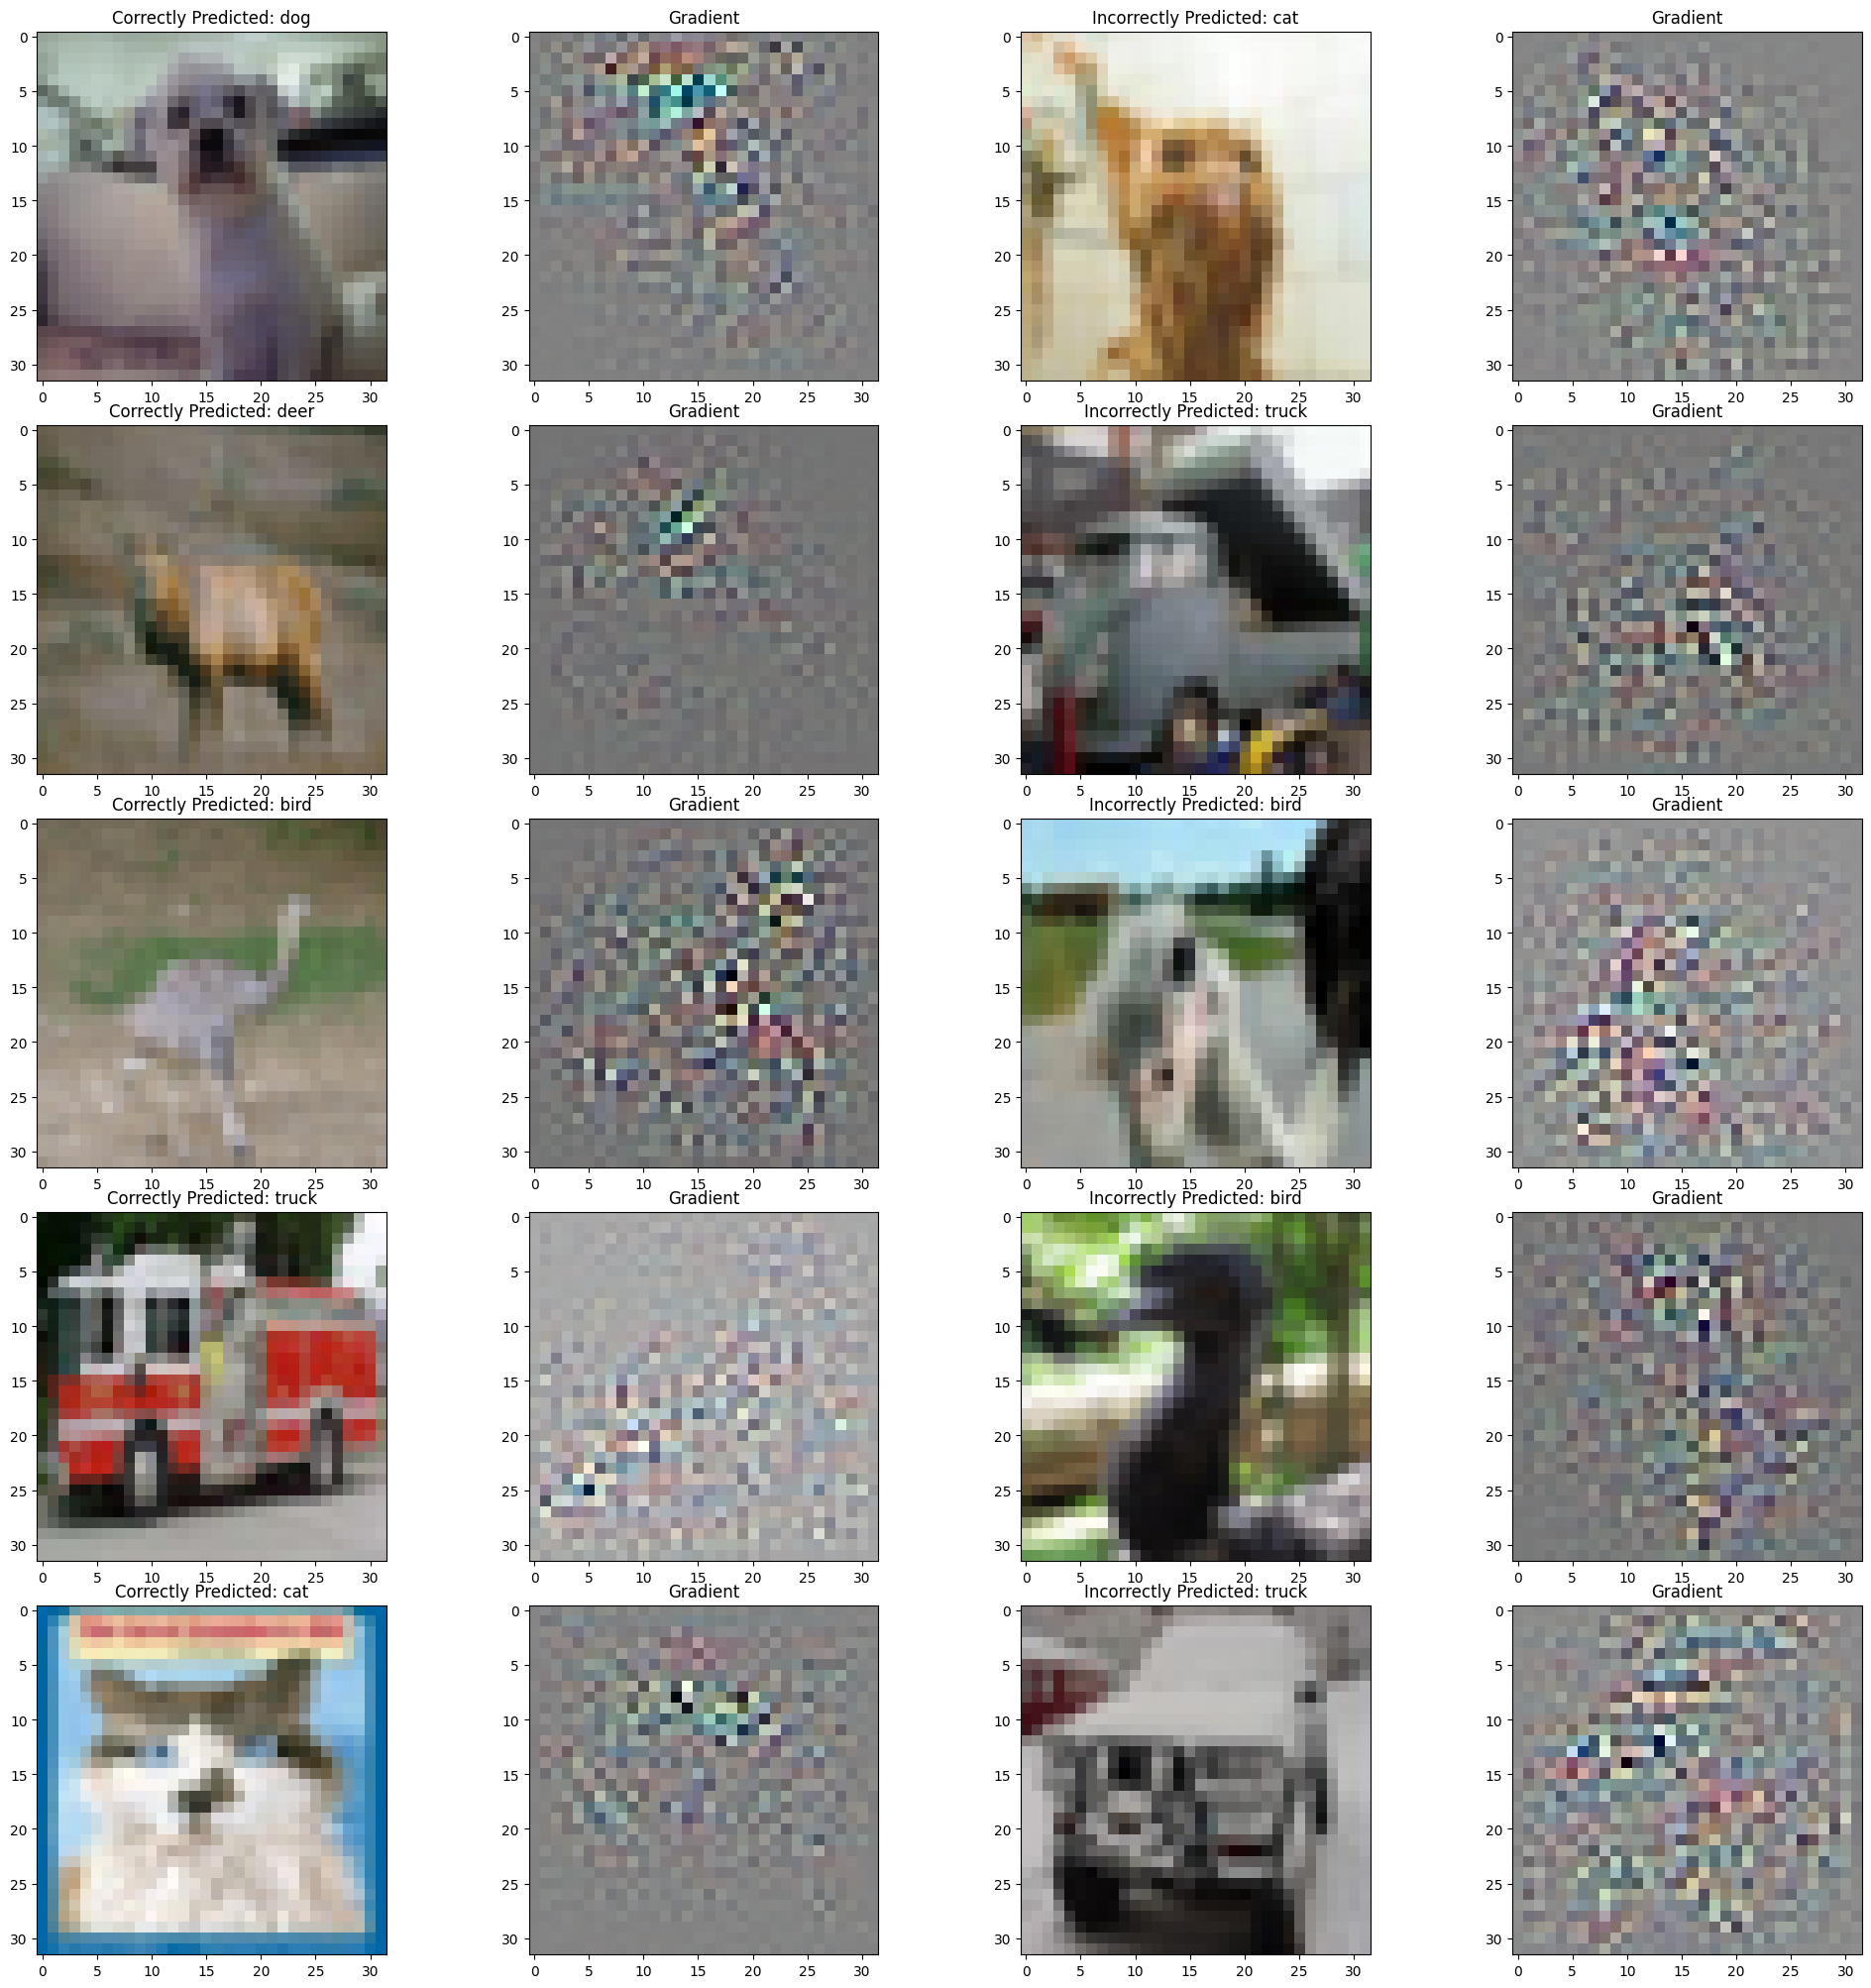

In [37]:
# Plot the gradients
# Randomly pick 5 correctly predicted images and 5 incorrectly predicted images
# Then scale both the original image and the gradients to be within 0-1
# Then plot the original image and the gradients side by side

import matplotlib.pyplot as plt

def plot_grads(imgs, dx_imgs, labels, correct_pred, incorrect_pred):
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))  # Adjusted to 10 rows
    fig.tight_layout()
    for i, idx in enumerate(correct_pred[0][:5]):
        img = imgs[idx].detach().cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5
        dx_img = dx_imgs[idx].transpose((1, 2, 0))
        dx_img = (dx_img - np.min(dx_img)) / (np.max(dx_img) - np.min(dx_img))
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"Correctly Predicted: {classes[labels[idx]]}")
        axs[i, 1].imshow(dx_img)
        axs[i, 1].set_title("Gradient")
    for i, idx in enumerate(incorrect_pred[0][:5]):
        img = imgs[idx].detach().cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5
        dx_img = dx_imgs[idx].transpose((1, 2, 0))
        dx_img = (dx_img - np.min(dx_img)) / (np.max(dx_img) - np.min(dx_img))
        axs[i, 2].imshow(img)
        axs[i, 2].set_title(f"Incorrectly Predicted: {classes[labels[idx]]}")
        axs[i, 3].imshow(dx_img)
        axs[i, 3].set_title("Gradient")
    plt.show()

plot_grads(imgs, dx_imgs, labels, correct_pred, incorrect_pred)

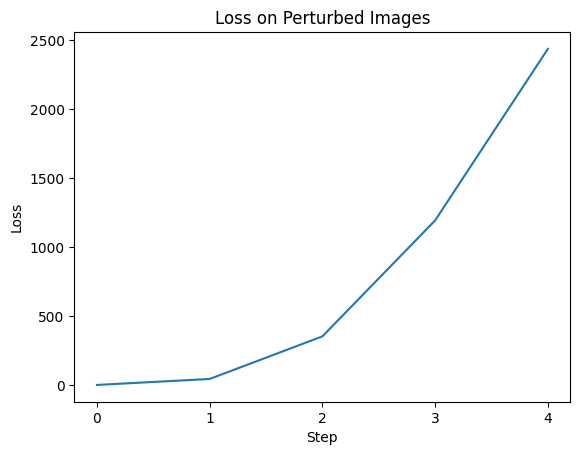

In [47]:
# 5-step signed gradient attack
# Pick epsilon = 8 (2^8 = 255)
# For a minibatch of 100, perturb all images 5 times using the signed gradient
# At each step, feed in the perturbed image from the previous step and perturb it a bit more
# Plot the loss on the perturbed images as a function of the number of steps in the attack averaged across your mini-batch

"""
xs , ys = mini-batch of inputs and targets
for x,y in zip(xs , ys):
    for k in range(5):
        # forward propagate x through the network
        # backprop the loss
        dx = ...
        x += eps*sign(dx)
        # record loss on the perturbed image
        ell = loss(x, y) 
"""

testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True)
imgs, labels = next(iter(testloader))
imgs = imgs.to(device)
labels = labels.to(device)

eps = 8

def signed_grad_attack(model, imgs, labels, eps, num_steps):
    imgs = imgs.clone().detach().requires_grad_(True)  # Clone and set requires_grad
    loss_perturbed = []
    for k in range(num_steps):
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss_perturbed.append(loss.item())
        loss.backward()
        if imgs.grad is not None:
            dx = imgs.grad.data.clone()
            imgs = imgs + eps * torch.sign(dx)
        imgs = imgs.detach().requires_grad_(True)  # Detach and set requires_grad for the next step
    return loss_perturbed

perturbed_imgs = signed_grad_attack(model, imgs, labels, eps, 5)
loss_perturbed = signed_grad_attack(model, imgs, labels, eps, 5)

plt.plot(loss_perturbed)
plt.xlabel('Step')
plt.xticks(range(len(loss_perturbed)))
plt.ylabel('Loss')
plt.title('Loss on Perturbed Images')
plt.show()


In [52]:
# Compute the accuracy of the network on 1-step perturbed images, 
# i.e., for every image in the validation set, perturb the image using a 1-step attack 
# and check the prediction of the network.

def one_step_attack(model, imgs, labels, eps):
    imgs = imgs.clone().detach().requires_grad_(True)  # Clone and set requires_grad
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    loss.backward()
    if imgs.grad is not None:
        dx = imgs.grad.data.clone()
        imgs = imgs + eps * torch.sign(dx)
    imgs = imgs.detach().requires_grad_(True)  # Detach and set requires_grad for the next step
    return imgs

def compute_accuracy(model, testloader, eps):
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(testloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        perturbed_imgs = one_step_attack(model, imgs, labels, eps)
        outputs = model(perturbed_imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

accuracy = compute_accuracy(model, testloader, eps)
print(f"Accuracy on 1-step perturbed images: {accuracy}%")

# Compare with the clean testset

def compute_accuracy_clean(model, testloader):
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(testloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

accuracy_clean = compute_accuracy_clean(model, testloader)

print(f"Accuracy on clean images: {accuracy_clean}%")

Accuracy on 1-step perturbed images: 9.34%
Accuracy on clean images: 86.3%


In [ ]:
# Automatically shutdown Colab

import time
time.sleep(10)

if 'google.colab' in str(get_ipython()):
    from google.colab import runtime
    runtime.unassign()